<a href="https://colab.research.google.com/github/AhmedYounes94/AraBERT-Diacritic-experiment/blob/Adding-Diacritics-to-all-data/AraBERTv2_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


#AraBERT for NER - on ANERCorp

ANERCorp:https://link.springer.com/chapter/10.1007/978-3-540-70939-8_13

We are using ANERCorp with Camel splits

The first part uses the Trainer API to quickly train the model


The second part defines a custom model and training loop which should be identical



**For AraBERTv1 and V2 you need to use the custom scripts** since the datasets library with the pyarrow backend dont support using farasapy

In [4]:
!pip install transformers
!pip install datasets
!pip install farasapy
!pip install pyarabic
!pip install seqeval
!pip install pytorch-crf
!git clone https://github.com/aub-mind/arabert

     |████████████████████████████████| 1.9MB 15.4MB/s 
     |████████████████████████████████| 3.2MB 46.2MB/s 
     |████████████████████████████████| 890kB 46.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=101c5b88e1931347deb2caf8dbe517045fd5d73516c6a2412648f8bcb32f217d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 184kB 18.7MB/s 
     |████████████████████████████████| 245kB 42.0MB/s 
     |████████████████████████████████| 112kB 52.0MB/s 
     |████████████████████████████████| 112kB 18.4MB/s 
  Created wheel for pyarabic: filename=PyArabic-0.6.10-cp37-none-any.whl size=113324 sha256=08c92356fe9db7d62c81d1f39e4b8d13bc6988e883e36ac741621277be9da8f7
  Stored in directory: /root/.cache/pip/wheels/10/b8/f5/b7c1a50e6efb83544844f165a9b134afe7292585465e29b61d
Successfully built pyarabic
     |████████████

In [5]:
# !unzip "/content/drive/MyDrive/ANERcorp-CamelLabSplits.zip"

#Reading Data

In [6]:
import numpy as np
import pandas as pd
from torchsummary import summary
from sklearn.model_selection import train_test_split



In [7]:
%cd /content/drive/My Drive/Undiacritic


/content/drive/My Drive/Undiacritic


In [8]:
ModelPath = 'NER/ANERCrop/Cross Validation/Models'
CrossPath = 'NER/ANERCrop/Cross Validation/Models'
BestPath = 'NER/ANERCrop/Cross Validation/Models'



In [9]:
# data_path = {'NER':'ANERCorp','NER':'BinAjeeba','POS':'PADT','POS':'Mushaf'}
# for t,dt in data_path.items():
#     excel_data = pd.read_excel(f'Final_{dt}.xlsx')
#     np.savetxt(f'{dt}.txt', excel_data.values, fmt='%s' )
   

In [10]:
# excel_data = pd.read_excel(f'Final_{dt}.xlsx')
# np.savetxt(f'NER/{dt}.txt', excel_data.values, fmt='%s' )


In [11]:
# !head -n100 ./ANERcorp-CamelLabSplits/ANERCorp_CamelLab_train.txt

In [12]:
from collections import Counter
import matplotlib.pyplot as plt

In [13]:
def read_ANERcorp(path):
  with open(path,'r',encoding='utf-8') as f:
    data = []
    sentence = []
    label = []
    for line in f:
      if line.split()[0]=='.':
        if len(sentence) > 0:
          data.append((sentence,label))
          sentence = []
          label = []
        continue
      splits = line.split()
      sentence.append(splits[0])
      label.append(splits[1])
    if len(sentence) > 0:
      data.append((sentence,label))
  return data

In [14]:
data_all = read_ANERcorp('data/ANERCorp.txt')
data_train, data_test = train_test_split(data_all,test_size = 0.2, random_state = 1 )



In [15]:
print(Counter([ label for sentence in data_test for label in sentence[1]]))
print(Counter([ label for sentence in data_train for label in sentence[1]]))

Counter({'O': 22659, 'B-LOC': 810, 'B-PERS': 697, 'I-PERS': 506, 'B-ORG': 394, 'I-ORG': 252, 'B-MISC': 217, 'I-MISC': 105, 'I-LOC': 97})
Counter({'O': 90688, 'B-LOC': 3459, 'B-PERS': 2743, 'I-PERS': 2196, 'B-ORG': 1520, 'I-ORG': 1046, 'B-MISC': 853, 'I-LOC': 489, 'I-MISC': 363})


In [16]:
label_list = list(Counter([ label for sentence in data_test for label in sentence[1]]).keys())
print(label_list)

['O', 'B-PERS', 'I-PERS', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC', 'B-ORG', 'I-ORG']


Training Sentence Lengths: 


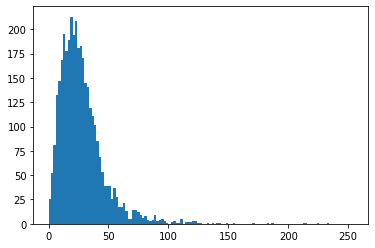

3
Testing Sentence Lengths: 


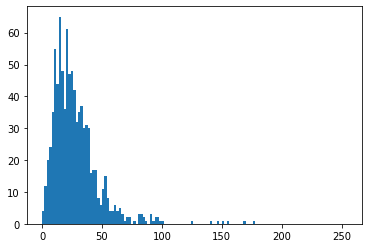

2


In [17]:
print("Training Sentence Lengths: ")
plt.hist([ len(sentence[0]) for sentence in data_train],bins=range(0,256,2))
plt.show()
print(sum([len(sentence[0]) > 512 for sentence in data_train]))

print("Testing Sentence Lengths: ")
plt.hist([ len(sentence[0]) for sentence in data_test],bins=range(0,256,2))
plt.show()
print(sum([len(sentence[0]) > 256 for sentence in data_test]))

#NER with Trainer

In [18]:
!wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/token-classification/run_ner.py

--2021-02-27 01:05:15--  https://raw.githubusercontent.com/huggingface/transformers/master/examples/token-classification/run_ner.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19188 (19K) [text/plain]
Saving to: ‘run_ner.py.4’

run_ner.py.4        100%[===================>]  18.74K  --.-KB/s    in 0.01s   

2021-02-27 01:05:15 (1.70 MB/s) - ‘run_ner.py.4’ saved [19188/19188]



Converting data to huggingface supported format
1 json per line with "tokens" and "ner_tags" as keys

close to this for format https://github.com/huggingface/transformers/blob/master/tests/fixtures/tests_samples/conll/sample.json

In [19]:
import json

with open("train_data.json", "w") as outfile:
  for examples in data_train:
    ex_dict = {
        "tokens":examples[0],
        "ner_tags":examples[1]
    }
    json.dump(ex_dict, outfile)
    outfile.write('\n')

with open("test_data.json", "w") as outfile:
  for examples in data_test:
    ex_dict = {
        "tokens":examples[0],
        "ner_tags":examples[1]
    }
    json.dump(ex_dict, outfile)
    outfile.write('\n')

In [20]:
# !python run_ner.py \
#   --model_name_or_path aubmindlab/bert-large-arabertv02 \
#   --train_file train_data.json \
#   --validation_file test_data.json \
#   --output_dir ./test-ner \
#   --do_train \
#   --do_eval \
#   --per_device_train_batch_size 4 \
#   --gradient_accumulation_steps 8 \
#   --learning_rate 3e-5 \
#   --num_train_epochs 10 \
#   --warmup_steps 0 \
#   --evaluation_strategy epoch \
#   --save_steps 10000 \
#   --overwrite_output_dir \
#   --seed 42 \
#   --fp16 \

#NER with custom Model

##Model Files

In [21]:

from sklearn import preprocessing
from sklearn import model_selection

from arabert.preprocess import ArabertPreprocessor, prefix_symbols , suffix_symblos

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import transformers
import torch

import torch.nn as nn
import numpy as np

import joblib
import pickle

from tqdm import tqdm_notebook as tqdm

from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

In [22]:
MAX_SEQ_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 5e-5
WARMUP_RATIO = 0.1
MAX_GRAD_NORM = 1.0
accumulation_steps = 1


#You can try other Arabic BERT models by just changing the path here
#In our tests AraBERT (v1&v0.1) outperformed all tested models :)
BASE_MODEL_PATH = 'aubmindlab/bert-base-arabertv02'
MODEL_PATH = "model.bin"
TOKENIZER = transformers.BertTokenizer.from_pretrained(
    BASE_MODEL_PATH,
    do_lower_case=False)
arabert_prep = ArabertPreprocessor(BASE_MODEL_PATH.split("/")[-1])

In [23]:
tokenized_data = []
for sentence in data_test:
  tokenized_sentence = []
  for word in sentence[0]:
    tokenized_sentence.extend(TOKENIZER.tokenize(word))
  tokenized_data.append(tokenized_sentence)

#checking if Max length is compatible with the test data and doesnt cut any sentence in the test data weh
print(sum([len(sentence[0]) > MAX_SEQ_LEN for sentence in tokenized_data]))

0


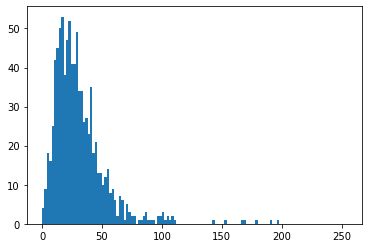

9


In [24]:
# check if the test_dataset is fully covered
tokenized_data = [TOKENIZER.tokenize(arabert_prep.preprocess(" ".join(sentence[0]))) for sentence in data_test]
plt.hist([ len(x) for x in tokenized_data],bins=range(0,256,2))
plt.show()
print(sum([len(x) > MAX_SEQ_LEN for x in tokenized_data]))

In [25]:
class NERDataset:
  def __init__(self, texts, tags, label_list, preprocessor):
    self.texts = texts
    self.tags = tags
    self.label_map = {label: i for i, label in enumerate(label_list)}
    self.preprocessor = preprocessor    
    # self.pad_token_label_id = nn.CrossEntropyLoss().ignore_index
    self.pad_token_label_id = 0


    # Use cross entropy ignore_index as padding label id so that only
    # real label ids contribute to the loss later.

     
  def __len__(self):
    return len(self.texts)
  
  def __getitem__(self, item):
    textlist = self.texts[item]
    tags = self.tags[item]

    tokens = []
    label_ids = []
    for word, label in zip(textlist, tags):      
      clean_word = self.preprocessor.preprocess(word)  
      word_tokens = TOKENIZER.tokenize(clean_word)

      if len(word_tokens) > 0:
        tokens.extend(word_tokens)    
        # Use the real label id for the first token of the word, and padding ids for the remaining tokens
        label_ids.extend([self.label_map[label]] + [self.pad_token_label_id] * (len(word_tokens) - 1))
 
    # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
    special_tokens_count = TOKENIZER.num_special_tokens_to_add()
    if len(tokens) > MAX_SEQ_LEN - special_tokens_count:
      tokens = tokens[: (MAX_SEQ_LEN - special_tokens_count)]
      label_ids = label_ids[: (MAX_SEQ_LEN - special_tokens_count)]
  
    #Add the [SEP] token
    tokens += [TOKENIZER.sep_token]
    label_ids += [self.pad_token_label_id]
    token_type_ids = [0] * len(tokens)

    #Add the [CLS] TOKEN
    tokens = [TOKENIZER.cls_token] + tokens
    label_ids = [self.pad_token_label_id] + label_ids
    token_type_ids = [0] + token_type_ids

    input_ids = TOKENIZER.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    attention_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    padding_length = MAX_SEQ_LEN - len(input_ids)

    input_ids += [TOKENIZER.pad_token_id] * padding_length
    attention_mask += [0] * padding_length
    token_type_ids += [0] * padding_length
    label_ids += [self.pad_token_label_id] * padding_length

    assert len(input_ids) == MAX_SEQ_LEN
    assert len(attention_mask) == MAX_SEQ_LEN
    assert len(token_type_ids) == MAX_SEQ_LEN
    assert len(label_ids) == MAX_SEQ_LEN

    # if item < 5:
    #   print("*** Example ***")
    #   print("tokens:", " ".join([str(x) for x in tokens]))
    #   print("input_ids:", " ".join([str(x) for x in input_ids]))
    #   print("attention_mask:", " ".join([str(x) for x in attention_mask]))
    #   print("token_type_ids:", " ".join([str(x) for x in token_type_ids]))
    #   print("label_ids:", " ".join([str(x) for x in label_ids]))
    
    return {
        'input_ids' : torch.tensor(input_ids, dtype=torch.long),
        'attention_mask' : torch.tensor(attention_mask, dtype=torch.long),
        'token_type_ids' : torch.tensor(token_type_ids, dtype=torch.long),
        'labels' : torch.tensor(label_ids, dtype=torch.long)       
    }


In [26]:
import torch.nn.functional as F
from torchcrf import CRF
log_soft = F.log_softmax


In [27]:

word = torch.randn([32, 100, 768])
bert = transformers.AutoModel.from_pretrained(BASE_MODEL_PATH)
out_tag = nn.Linear(768 , 9)        
crf = CRF(9, batch_first=True)


  

In [28]:
# for data in tqdm(test_dataloader, total=len(test_dataloader)):
#         word = torch.randn([8, 128, 768])
#         out = out_tag(word)
#         logits = crf.decode(out)
#         # print(torch.Tensor(logits).shape)
#         # print(data['input_ids'].shape)
        

In [29]:
def loss_fn(output, target, mask, num_labels):
    lfn = nn.CrossEntropyLoss()
    active_loss = mask.view(-1) == 1
    active_logits = output.view(-1, num_labels)
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target)
    )
    loss = lfn(active_logits, active_labels)
    return loss


class NERModel(nn.Module):
    def __init__(self, num_tag):
        super(NERModel, self).__init__()
        self.num_tag = num_tag
        self.bert = transformers.AutoModel.from_pretrained(BASE_MODEL_PATH)
        self.bert_drop = nn.Dropout(0.3)
        self.out_tag = nn.Linear(self.bert.config.hidden_size, self.num_tag)
        self.crf = CRF(self.num_tag, batch_first=True)    

 
    def forward(self, input_ids, attention_mask, token_type_ids, labels):
        output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids,output_hidden_states=True)
        bo_tag = self.bert_drop(output['last_hidden_state'])
        out = self.out_tag(bo_tag)
        # logits = self.out_tag(bo_tag)

        # loss_tag = loss_fn(logits, labels, attention_mask, self.num_tag)
        attention_mask = attention_mask.type(torch.uint8)
        loss_tag = -self.crf(log_soft(out, 2), labels, reduction='mean')
        logits = self.crf.decode(out)

        return loss_tag, logits

In [30]:

inv_label_map = {i: label for i, label in enumerate(label_list)}

def align_predictions(predictions, label_ids):
    # print('label_ids', label_ids[0])
    # print('label_ids shape', label_ids.shape)
    # print('predictions shape',predictions.shape)
    # preds = np.argmax(predictions, axis=2)
    preds = predictions

    # print('preds',preds[0])
    # print('preds shape',preds.shape)
  

    batch_size, seq_len = preds.shape

    out_label_list = [[] for _ in range(batch_size)]
    preds_list = [[] for _ in range(batch_size)]

    for i in range(batch_size):
        for j in range(seq_len):
            # if label_ids[i, j] != nn.CrossEntropyLoss().ignore_index:
            if label_ids[i, j] != 0:
                out_label_list[i].append(inv_label_map[label_ids[i][j]])
                preds_list[i].append(inv_label_map[preds[i][j]])

    return preds_list, out_label_list

def compute_metrics(predictions,label_ids):
    preds_list, out_label_list = align_predictions(predictions, label_ids)
    print(classification_report(out_label_list, preds_list,digits=4))
    raw = classification_report(out_label_list, preds_list,digits=4)
    return {
        "accuracy_score": accuracy_score(out_label_list, preds_list),
        "precision": precision_score(out_label_list, preds_list),
        "recall": recall_score(out_label_list, preds_list),
        "f1": f1_score(out_label_list, preds_list),
        "classification": create_classification_report(raw),}
    # }, create_classification_report(raw)

In [31]:
def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train()
    final_loss = 0
    for i, data in enumerate(tqdm(data_loader, total=len(data_loader))):
        for k, v in data.items():
            data[k] = v.to(device)
        outputs = model(**data)
        loss = outputs[0]
        # loss = outputs
        loss.backward()
        final_loss += loss.item()
        if (i + 1 ) % accumulation_steps == 0:
          torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
          optimizer.step()
          scheduler.step()          
          optimizer.zero_grad()
    return final_loss / len(data_loader)

def eval_fn(data_loader, model, device):
    model.eval()
    with torch.no_grad():
      final_loss = 0
      preds= None
      labels = None
      for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        outputs = model(**data)
        loss = outputs[0]
        logits = torch.tensor(outputs[1],dtype=torch.long)
        final_loss += loss.item()
        if logits is not None:   
          preds = logits if preds is None else torch.cat((preds, logits), dim=0)
        if data['labels'] is not None:
          labels = data['labels'] if labels is None else torch.cat((labels, data['labels']), dim=0)
      preds = preds.detach().cpu().numpy()
      labels = labels.cpu().numpy()  
      # preds = logits.detach().cpu().numpy()
      # labels = labels.cpu().numpy()   
      metrics = compute_metrics(preds,labels)
      report = metrics.pop('classification')
      results = metrics
    
    return results, report, final_loss
    # return compute_metrics(preds,labels)

In [32]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Sat Feb 27 01:05:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                            

##Training on all the training data


In [33]:
def create_classification_report(raw):
  report = raw.strip().split('\n')
  lines = []
  for line in report[1:]:
    tokens = line.split()
    if line!='':
      if len(tokens)>5:
          del tokens[1]
        
      lines.append(tokens)
  return pd.DataFrame(lines, columns=['class', 'precision', 'recall', 'f1-score', 'support'])


In [34]:

train_dataset = NERDataset(
    texts= [x[0] for x in data_train],
    tags = [x[1] for x in data_train],
    label_list = label_list,
    preprocessor=arabert_prep)

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=2
)

test_dataset = NERDataset(
    texts= [x[0] for x in data_test],
    tags = [x[1] for x in data_test],
    label_list = label_list,
    preprocessor=arabert_prep)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=VALID_BATCH_SIZE,
    num_workers=1
)

In [35]:
EPOCHS = 2
import time
from sklearn.model_selection import KFold

kf = KFold(n_splits=2,shuffle=False, random_state=42)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [118]:
# num_tag = len(label_list)
# epochs = []
# folds = []
# epochs = []
# model = NERModel(num_tag=num_tag)
# model.to(device)
# print('MODEL LOADED!')

# param_optimizer = list(model.named_parameters())
# no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
# optimizer_parameters = [
#     {
#         "params": [
#             p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
#         ],
#         "weight_decay": 0.01,
#     },
#     {
#         "params": [
#             p for n, p in param_optimizer if any(nd in n for nd in no_decay)
#         ],
#         "weight_decay": 0.0,
#     },
# ]

# num_train_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCHS)
# print('Number of training steps: ', num_train_steps)
# optimizer = AdamW(optimizer_parameters, lr=LEARNING_RATE)
# scheduler = get_linear_schedule_with_warmup(
#     optimizer, num_warmup_steps=int(WARMUP_RATIO*num_train_steps), num_training_steps=num_train_steps
# )
epochs = []
folds = []
fold_best_f1 = 0
best_fold = None
for fold_num , (train, test) in enumerate(kf.split(data_all)):
  print("Starting Fold Num: ", fold_num)
  train_dataset = NERDataset(
    texts= [x[0] for x in [data_all[x] for x in train]],
    tags = [x[1] for x in [data_all[x] for x in train]],
    label_list = label_list,
    preprocessor=arabert_prep)

  train_dataloader = torch.utils.data.DataLoader(
      dataset=train_dataset,
      batch_size=TRAIN_BATCH_SIZE,
      num_workers=2
  )

  test_dataset = NERDataset(
      texts= [x[0] for x in [ data_all[x] for x in test]],
      tags = [x[1] for x in [ data_all[x] for x in test]],
      label_list = label_list,
      preprocessor=arabert_prep)

  test_dataloader = torch.utils.data.DataLoader(
      dataset=test_dataset,
      batch_size=VALID_BATCH_SIZE,
      num_workers=1
  )
  num_tag = len(label_list)
  model = NERModel(num_tag=num_tag)
  model.to(device)
  print('MODEL LOADED!')

  param_optimizer = list(model.named_parameters())
  no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
  optimizer_parameters = [
      {
          "params": [
              p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.01,
      },
      {
          "params": [
              p for n, p in param_optimizer if any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.0,
      },
  ]

  num_train_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCHS)
  print('Number of training steps: ', num_train_steps)
  optimizer = AdamW(optimizer_parameters, lr=LEARNING_RATE)
  scheduler = get_linear_schedule_with_warmup(
      optimizer, num_warmup_steps=int(WARMUP_RATIO*num_train_steps), num_training_steps=num_train_steps
  )

  tr_start_time = time.time()
  for i,epoch in enumerate(range(EPOCHS)):
      epoch_start_time = time.time()
      train_loss = train_fn(train_dataloader, model, optimizer, device, scheduler)
      eval_metrics, report, eval_loss = eval_fn(test_dataloader, model, device)
      print(f"Train Loss = {train_loss} Valid Loss = {eval_loss}")
      print(eval_metrics)
      history = {f'epoch({i})':{'loss':{'train Loss': train_loss, 'valid Loss': eval_loss}, 'metrics':eval_metrics, 'time':time.time() - epoch_start_time}}
      epochs.append(history)
      print('Epoch finished, took {:.2f}s'.format(time.time() - epoch_start_time))
  print('train finished, took {:.2f}s'.format(time.time() - tr_start_time))
  fold = {f'fold({fold_num})':{'fold_results':eval_metrics ,'fold_report': report, 'fold_time': time.time() - tr_start_time, 'model':model, 'epochs': epochs}}
  folds.append(fold)
  epochs = []



Starting Fold Num:  0
MODEL LOADED!
Number of training steps:  279


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



              precision    recall  f1-score   support

         LOC     0.9277    0.8906    0.9088      2304
        MISC     0.6959    0.3206    0.4390       471
         ORG     0.7807    0.6344    0.7000       651
        PERS     0.9015    0.9175    0.9094      1406

   micro avg     0.8900    0.8084    0.8472      4832
   macro avg     0.8264    0.6908    0.7393      4832
weighted avg     0.8776    0.8084    0.8350      4832

Train Loss = 33.32259455578668 Valid Loss = 797.5527117848396
{'accuracy_score': 0.8126805314846909, 'precision': 0.8899521531100478, 'recall': 0.8083609271523179, 'f1': 0.8471966164190434}
Epoch finished, took 105.86s



              precision    recall  f1-score   support

         LOC     0.9412    0.8963    0.9182      2304
        MISC     0.6256    0.5605    0.5913       471
         ORG     0.8485    0.6713    0.7496       651
        PERS     0.9242    0.9189    0.9215      1406

   micro avg     0.8960    0.8398    0.8670      4832
   macro avg     0.8349    0.7617    0.7951      4832
weighted avg     0.8930    0.8398    0.8646      4832

Train Loss = 2.166064620443753 Valid Loss = 771.5730844736099
{'accuracy_score': 0.8463316002310803, 'precision': 0.896003532788695, 'recall': 0.839817880794702, 'f1': 0.8670013887405191}
Epoch finished, took 107.85s
train finished, took 213.70s
Starting Fold Num:  1
MODEL LOADED!
Number of training steps:  279



              precision    recall  f1-score   support

         LOC     0.8986    0.9309    0.9145      1838
        MISC     0.6519    0.4380    0.5240       573
         ORG     0.7655    0.7027    0.7328      1157
        PERS     0.9349    0.8919    0.9129      1869

   micro avg     0.8652    0.8170    0.8404      5437
   macro avg     0.8128    0.7409    0.7710      5437
weighted avg     0.8568    0.8170    0.8341      5437

Train Loss = 24.43576934635639 Valid Loss = 866.9720653295517
{'accuracy_score': 0.8257992007992008, 'precision': 0.8652123100895988, 'recall': 0.8169946661762001, 'f1': 0.8404124491533441}
Epoch finished, took 108.83s



              precision    recall  f1-score   support

         LOC     0.9277    0.9429    0.9352      1838
        MISC     0.6742    0.5201    0.5872       573
         ORG     0.8255    0.7606    0.7917      1157
        PERS     0.9318    0.9058    0.9186      1869

   micro avg     0.8866    0.8468    0.8662      5437
   macro avg     0.8398    0.7823    0.8082      5437
weighted avg     0.8806    0.8468    0.8623      5437

Train Loss = 1.9548201652509825 Valid Loss = 818.7733807563782
{'accuracy_score': 0.8577672327672328, 'precision': 0.886578085884845, 'recall': 0.8467905094721354, 'f1': 0.866227657572907}
Epoch finished, took 109.46s
train finished, took 218.29s


In [133]:
import pickle as pkl
CrossPath = "/content/drive/My Drive/Undiacritic/NER/ANERCorp/Cross Validation/"
BestPath = "/content/drive/My Drive/Undiacritic/NER/ANERCorp/Cross Validation/Best Runs/"

In [134]:
def extract_folds(folds):
    fs = []
    ind = []
    outfile = open(CrossPath+'RawAnalysis.pkl','wb')
    pkl.dump(folds, outfile)
    for fold in range(len(folds)):
      result = folds[fold][f'fold({fold})']['fold_results']
      result['time'] = folds[fold][f'fold({fold})']['fold_time']
      report = folds[fold][f'fold({fold})']['fold_report']
      report.to_excel(CrossPath+f'fold({fold})_report.xlsx')
      res = pd.DataFrame(result.items()).T
      new_header = res.iloc[0] 
      df = res[1:] 
      df.columns = new_header
      fs.append(df)
      ind.append(f'fold ({fold})')
    df = pd.concat(fs)
    df.index = ind
    df.to_excel(CrossPath+'CrossValidationResult.xlsx')


In [135]:
def extract_epochs(folds):
    cols = []
    losses = []
    metrics = []
    times = []
    ind = []
    for fold in range(len(folds)):
      for ep in folds[fold][f'fold({fold})']['epochs']:
        cols.append(list(ep.keys())[0])
        comp = list(ep.values())[0]
        loss = pd.DataFrame(comp['loss'].items()).T
        new_header = loss.iloc[0] 
        loss = loss[1:] 
        loss.columns = new_header
        losses.append(loss)
        metric = pd.DataFrame(comp['metrics'].items()).T
        new_header = metric.iloc[0] 
        metric = metric[1:] 
        metric.columns = new_header
        metrics.append(metric)
        times.append(comp['time'])
        mt = pd.concat(metrics).reset_index().drop('index', axis = 1)
        ls = pd.concat(losses).reset_index().drop('index', axis = 1)
        mt['time'] = times
        conmput = ls.merge(mt, left_index=True, right_index=True)
        conmput['epoch_time']= times
        ind.append(f'fold ({fold})')
    conmput.index = ind
    conmput.to_excel(CrossPath+'epochs_history.xlsx')

In [159]:
def read_file(filename): 
    outputfile = open(filename,'rb')
    return pkl.load(outputfile)


In [136]:
extract_folds(folds)
extract_epochs(folds)

In [74]:

epochs = []
folds = []
fold_best_f1 = 0
best_fs = []
best_folds = []
best_fold = None
for upper_fold_num , (upper_train, test) in enumerate(kf.split(data_all)):
  print("Starting Split Num: ", upper_fold_num)
  train_dataset = NERDataset(
    texts= [x[0] for x in [data_all[x] for x in upper_train]],
    tags = [x[1] for x in [data_all[x] for x in upper_train]],
    label_list = label_list,
    preprocessor=arabert_prep)

  train_dataloader = torch.utils.data.DataLoader(
      dataset=train_dataset,
      batch_size=TRAIN_BATCH_SIZE,
      num_workers=2
  )

  test_dataset = NERDataset(
      texts= [x[0] for x in [ data_all[x] for x in test]],
      tags = [x[1] for x in [ data_all[x] for x in test]],
      label_list = label_list,
      preprocessor=arabert_prep)

  test_dataloader = torch.utils.data.DataLoader(
      dataset=test_dataset,
      batch_size=VALID_BATCH_SIZE,
      num_workers=1
  )
  data_train = [data_all[t] for t in upper_train]


  for fold_num , (train, dev) in enumerate(kf.split(data_train)):
    print("Starting Fold Num: ", fold_num)
    train_dataset = NERDataset(
      texts= [x[0] for x in [data_train[x] for x in train]],
      tags = [x[1] for x in [data_train[x] for x in train]],
      label_list = label_list,
      preprocessor=arabert_prep)

    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        num_workers=2
    )

    dev_dataset = NERDataset(
        texts= [x[0] for x in [ data_train[x] for x in dev]],
        tags = [x[1] for x in [ data_train[x] for x in dev]],
        label_list = label_list,
      preprocessor=arabert_prep)

    dev_dataloader = torch.utils.data.DataLoader(
        dataset=dev_dataset,
        batch_size=VALID_BATCH_SIZE,
        num_workers=1
    )
    
    num_tag = len(label_list)
    model = NERModel(num_tag=num_tag)
    model.to(device)
    print('MODEL LOADED!')

    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.01,
        },
        {
            "params": [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]

    num_train_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCHS)
    print('Number of training steps: ', num_train_steps)
    optimizer = AdamW(optimizer_parameters, lr=LEARNING_RATE)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=int(WARMUP_RATIO*num_train_steps), num_training_steps=num_train_steps
    )
    
    for epoch in range(EPOCHS):
        train_loss = train_fn(train_dataloader, model, optimizer, device, scheduler)
        eval_metrics, _, eval_loss = eval_fn(dev_dataloader, model, device)
        print(f"Train Loss = {train_loss} Valid Loss = {eval_loss}")
        print(eval_metrics)
        if eval_metrics['f1'] > fold_best_f1:
          print('New Best Model Found!')
          fold_best_f1 = eval_metrics['f1']
          best_fold = fold_num
          print(f'best f1: {fold_best_f1}')
          torch.save(model.state_dict(), BestPath+f'Best Models/fold({int(fold_best_f1*100)})model.bin')
          best_fs.append(fold_best_f1)
          best_folds.append(best_fold)
  model.load_state_dict(torch.load(BestPath+f'Best Models/fold({int(fold_best_f1*100)})model.bin'))
  eval_metrics, report, eval_loss = eval_fn(test_dataloader, model, device)
  fold = {f'fold({upper_fold_num})':{'fold_results':eval_metrics ,'fold_report': report}}
  folds.append(fold)

Starting Split Num:  0
Starting Fold Num:  0
MODEL LOADED!
Number of training steps:  139


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



              precision    recall  f1-score   support

         LOC     0.8784    0.8642    0.8712      1053
        MISC     0.7333    0.0786    0.1419       280
         ORG     0.6336    0.6692    0.6509       535
        PERS     0.9084    0.9009    0.9047       848

   micro avg     0.8309    0.7563    0.7918      2716
   macro avg     0.7884    0.6282    0.6422      2716
weighted avg     0.8246    0.7563    0.7631      2716

Train Loss = 32.96168760231563 Valid Loss = 555.5177147984505
{'accuracy_score': 0.7700400801603207, 'precision': 0.830906148867314, 'recall': 0.7562592047128129, 'f1': 0.7918272937548188}
New Best Model Found!
best f1: 0.7918272937548188



              precision    recall  f1-score   support

         LOC     0.9084    0.8851    0.8966      1053
        MISC     0.5618    0.3571    0.4367       280
         ORG     0.7840    0.7533    0.7684       535
        PERS     0.9355    0.9233    0.9294       848

   micro avg     0.8681    0.8166    0.8416      2716
   macro avg     0.7974    0.7297    0.7577      2716
weighted avg     0.8566    0.8166    0.8342      2716

Train Loss = 3.487129487310137 Valid Loss = 431.990747153759
{'accuracy_score': 0.8289078156312625, 'precision': 0.8681017612524462, 'recall': 0.8166421207658321, 'f1': 0.8415860368051603}
New Best Model Found!
best f1: 0.8415860368051603
Starting Fold Num:  1
MODEL LOADED!
Number of training steps:  139



              precision    recall  f1-score   support

         LOC     0.7633    0.8752    0.8154       785
        MISC     0.9022    0.2833    0.4312       293
         ORG     0.7189    0.6865    0.7023       622
        PERS     0.8859    0.8139    0.8484      1021

   micro avg     0.8035    0.7453    0.7733      2721
   macro avg     0.8176    0.6647    0.6993      2721
weighted avg     0.8141    0.7453    0.7606      2721

Train Loss = 39.61262416499002 Valid Loss = 580.6998097002506
{'accuracy_score': 0.7547310756972112, 'precision': 0.803486529318542, 'recall': 0.7453142227122381, 'f1': 0.773307912297426}



              precision    recall  f1-score   support

         LOC     0.8650    0.9465    0.9039       785
        MISC     0.6647    0.3925    0.4936       293
         ORG     0.8327    0.6961    0.7583       622
        PERS     0.9031    0.8668    0.8846      1021

   micro avg     0.8594    0.7997    0.8285      2721
   macro avg     0.8164    0.7255    0.7601      2721
weighted avg     0.8503    0.7997    0.8192      2721

Train Loss = 2.7946221509150098 Valid Loss = 490.1764168739319
{'accuracy_score': 0.8047808764940239, 'precision': 0.8593996840442338, 'recall': 0.7997059904446895, 'f1': 0.8284789644012946}



              precision    recall  f1-score   support

         LOC     0.9066    0.8555    0.8803      2304
        MISC     0.4375    0.2824    0.3432       471
         ORG     0.7651    0.5853    0.6632       651
        PERS     0.9179    0.9061    0.9120      1406

   micro avg     0.8614    0.7779    0.8175      4832
   macro avg     0.7568    0.6573    0.6997      4832
weighted avg     0.8451    0.7779    0.8079      4832

Starting Split Num:  1
Starting Fold Num:  0
MODEL LOADED!
Number of training steps:  139



              precision    recall  f1-score   support

         LOC     0.8133    0.8956    0.8525      1226
        MISC     0.3571    0.0478    0.0844       209
         ORG     0.3922    0.1657    0.2330       362
        PERS     0.9304    0.9407    0.9355       725

   micro avg     0.8171    0.7335    0.7731      2522
   macro avg     0.6233    0.5125    0.5264      2522
weighted avg     0.7487    0.7335    0.7238      2522

Train Loss = 39.74394789423261 Valid Loss = 584.453380132094
{'accuracy_score': 0.7313638873550524, 'precision': 0.8171378091872792, 'recall': 0.7335448057097541, 'f1': 0.7730881738403677}



              precision    recall  f1-score   support

         LOC     0.9084    0.8980    0.9032      1226
        MISC     0.6757    0.2392    0.3534       209
         ORG     0.7537    0.5663    0.6467       362
        PERS     0.9384    0.9448    0.9416       725

   micro avg     0.8920    0.8093    0.8486      2522
   macro avg     0.8190    0.6621    0.7112      2522
weighted avg     0.8755    0.8093    0.8318      2522

Train Loss = 3.0031995015484947 Valid Loss = 463.0975219011307
{'accuracy_score': 0.804527885146328, 'precision': 0.8920454545454546, 'recall': 0.8092783505154639, 'f1': 0.8486486486486488}
New Best Model Found!
best f1: 0.8486486486486488
Starting Fold Num:  1
MODEL LOADED!
Number of training steps:  139



              precision    recall  f1-score   support

         LOC     0.8333    0.8302    0.8318      1078
        MISC     0.0000    0.0000    0.0000       262
         ORG     0.5787    0.3945    0.4691       289
        PERS     0.6301    0.6329    0.6315       681

   micro avg     0.7366    0.6234    0.6753      2310
   macro avg     0.5105    0.4644    0.4831      2310
weighted avg     0.6470    0.6234    0.6330      2310

Train Loss = 43.945821854046415 Valid Loss = 607.3549573421478
{'accuracy_score': 0.6432465172622653, 'precision': 0.7365728900255755, 'recall': 0.6233766233766234, 'f1': 0.675263774912075}


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



              precision    recall  f1-score   support

         LOC     0.9070    0.9045    0.9057      1078
        MISC     0.7674    0.1260    0.2164       262
         ORG     0.6345    0.5467    0.5874       289
        PERS     0.8834    0.8678    0.8756       681

   micro avg     0.8630    0.7606    0.8086      2310
   macro avg     0.7981    0.6112    0.6463      2310
weighted avg     0.8501    0.7606    0.7788      2310

Train Loss = 2.87734016196004 Valid Loss = 458.7550508379936
{'accuracy_score': 0.771350696547547, 'precision': 0.8629666011787819, 'recall': 0.7606060606060606, 'f1': 0.8085595950299126}



              precision    recall  f1-score   support

         LOC     0.8522    0.9412    0.8945      1838
        MISC     0.6455    0.2129    0.3202       573
         ORG     0.6538    0.5255    0.5827      1157
        PERS     0.9110    0.8876    0.8992      1869

   micro avg     0.8288    0.7576    0.7916      5437
   macro avg     0.7656    0.6418    0.6741      5437
weighted avg     0.8084    0.7576    0.7692      5437



In [125]:
def extract_best_folds(folds):
  fs = []
  ind = []
  for fold in range(len(folds)):
    result = folds[fold][f'fold({fold})']['fold_results']
    report = folds[fold][f'fold({fold})']['fold_report']
    report.to_excel(BestPath+f'Best Results/fold({fold})_best_report.xlsx')
    res = pd.DataFrame(result.items()).T
    new_header = res.iloc[0] 
    df = res[1:] 
    df.columns = new_header
    fs.append(df)
    ind.append(f'fold ({fold})')
  df = pd.concat(fs)
  df.index = ind
  df.to_excel(BestPath+'Best Results/CrossValidationBestResult.xlsx')


In [79]:
df

,accuracy_score,precision,recall,f1
fold (0),0.783073,0.861366,0.777939,0.817529
fold (1),0.767732,0.828773,0.757587,0.791583


#Results and hyper parameters

AraBERTv1

                  precision    recall  f1-score   support

             LOC     0.8919    0.9275    0.9094       676
            MISC     0.7389    0.6173    0.6726       243
             ORG     0.7748    0.6972    0.7339       459
            PERS     0.8499    0.8320    0.8409       905

       micro avg     0.8390    0.8103    0.8244      2283
       macro avg     0.8139    0.7685    0.7892      2283
    weighted avg     0.8354    0.8103    0.8217      2283

    Train Loss = 0.02561288744304329
    Valid Loss = 18.984092206461355
    'accuracy_score': 0.9703493257572726
    'precision': 0.8390022675736961
    'recall': 0.8103372755146737
    'f1': 0.8244206773618539

    MAX_SEQ_LEN = 256
    TRAIN_BATCH_SIZE = 32
    VALID_BATCH_SIZE = 8
    EPOCHS = 5
    LEARNING_RATE = 7e-5
    WARMUP_RATIO = 0.1
    MAX_GRAD_NORM = 1.0

AraBERTv0.2

                precision    recall  f1-score   support

           LOC     0.8886    0.9320    0.9097       676
          MISC     0.7590    0.6091    0.6758       243
           ORG     0.7935    0.7451    0.7685       459
          PERS     0.8832    0.8442    0.8633       905

      micro avg     0.8564    0.8252    0.8405      2283
      macro avg     0.8311    0.7826    0.8043      2283
      weighted avg     0.8536    0.8252    0.8380      2283

      Train Loss = 0.018847705767024308
      Valid Loss = 18.27915945305722
      'accuracy_score': 0.9722211071414235
      'precision': 0.8563636363636363
      'recall': 0.8252299605781866
      'f1': 0.8405085879991078

      MAX_SEQ_LEN = 256
      TRAIN_BATCH_SIZE = 32
      VALID_BATCH_SIZE = 8
      EPOCHS = 6
      LEARNING_RATE = 5e-5
      WARMUP_RATIO = 0.1
      MAX_GRAD_NORM = 1.0

AraELECTRA

                  precision    recall  f1-score   support

             LOC     0.8914    0.9349    0.9126       676
            MISC     0.7241    0.6049    0.6592       243
             ORG     0.8292    0.7298    0.7764       459
            PERS     0.8908    0.8475    0.8686       905

        micro avg     0.8640    0.8239    0.8435      2283
        macro avg     0.8339    0.7793    0.8042      2283
     weighted avg     0.8609    0.8239    0.8408      2283

    Train Loss = 0.012127994215115906
    Valid Loss = 20.18689019192243
    'accuracy_score': 0.9724218216851993
    'precision': 0.8640330730362885
    'recall': 0.823915900131406
    'f1': 0.8434977578475337}

    MAX_SEQ_LEN = 256
    TRAIN_BATCH_SIZE = 32
    VALID_BATCH_SIZE = 8
    EPOCHS = 10 # only 9 needed
    LEARNING_RATE = 5e-5
    WARMUP_RATIO = 0.1
    MAX_GRAD_NORM = 1.0